# Temporal Trend Analysis of Urban Morphology Sustainability  
## Mecklenburg County (1990–2023)

### Research Question
Has urban morphology in Mecklenburg County exhibited a trend toward greater
sustainability over time?

### Operational Definition of “Trend”
A temporal trend is defined as a **persistent, statistically identifiable
directional change** in an annual urban morphology indicator over the study
period.

Trend is evaluated using:
1. Long-term smoothing and signal extraction  
2. Formal monotonic and parametric trend tests  
3. Structural break analysis to detect regime changes  
4. Distributional and density-based diagnostics


In [1]:
# ============================================================
# Tier 0 — Setup
# ============================================================
import warnings
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from rpy2.robjects.lib.dplyr import summarize

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from scipy.stats import gaussian_kde
import ruptures as rpt
from pymannkendall import original_test as mk_test

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.3f}".format)
pio.renderers.default = "notebook_connected"


In [2]:
# ============================================================
# Tier 0 — Load & Filter Data
# ============================================================
ABT = gpd.read_file(
    "../../../../Data/Final_dataset/ABT/ABT.gpkg",
    layer="subdivisions"
)

ABT = ABT[(ABT["year"] >= 1990) & (ABT["year"] <= 2023)]

In [92]:
measure = "COMPACTNESS_SUM"

# ============================================================
# Tier 1 — Annual Distributional Summary Series
# ============================================================
This tier constructs annual time series capturing **central tendency**
(mean, median) and **dispersion** (standard deviation, interquartile range).


In [93]:
annual_stats = (
    ABT.groupby("year")[measure]
    .agg(
        mean="mean",
        median="median",
        std="std",
        iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
    )
    .reset_index()
)

years = annual_stats["year"].values
annual_stats

,year,mean,median,std,iqr
0,1990.000,0.052,0.032,0.089,0.009
1,1991.000,0.060,0.033,0.093,0.009
2,1992.000,0.057,0.031,0.089,0.010
3,1993.000,0.062,0.033,0.095,0.013
4,1994.000,0.056,0.032,0.083,0.010
5,1995.000,0.057,0.033,0.086,0.011
6,1996.000,0.070,0.035,0.106,0.011
7,1997.000,0.066,0.033,0.101,0.011
8,1998.000,0.061,0.034,0.092,0.011
9,1999.000,0.081,0.035,0.117,0.011


# ============================================================
# Tier 2 — Generalized Temporal Trend Diagnostics
# ============================================================
The following function applies **identical temporal diagnostics** to any
annual series, ensuring symmetry across mean, median, and dispersion measures.


In [94]:
def run_trend_diagnostics(years, series, label, lowess_frac=0.25):
    # -----------------------------
    # Stationarity diagnostics
    # -----------------------------
    adf_p = adfuller(series)[1]
    kpss_p = kpss(series, nlags="auto")[1]

    print(f"\n{label} — Stationarity")
    print(f"ADF p-value  : {adf_p:.4f}")
    print(f"KPSS p-value : {kpss_p:.4f}")

    # -----------------------------
    # LOWESS smoothing
    # -----------------------------
    trend = lowess(series, years, frac=lowess_frac)[:, 1]

    # -----------------------------
    # Visual trend
    # -----------------------------
    plt.figure(figsize=(14, 5))
    plt.plot(years, series, alpha=0.4, label="Observed")
    plt.plot(years, trend, linewidth=3, label="LOWESS")
    plt.title(f"{label}: Long-Term Trend")
    plt.xlabel("Year")
    plt.ylabel(label)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # -----------------------------
    # Derivatives
    # -----------------------------
    slope = np.gradient(trend, years)
    acceleration = np.gradient(slope, years)

    # -----------------------------
    # Mann–Kendall
    # -----------------------------
    mk = mk_test(series)
    print(f"{label} — Mann–Kendall")
    print(f"Trend: {mk.trend}")
    print(f"Sen slope: {mk.slope:.4f}")
    print(f"p-value: {mk.p:.4f}")

    # -----------------------------
    # HAC linear trend
    # -----------------------------
    X = sm.add_constant(years)
    model = sm.OLS(series, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": 2}
    )
    print(model.summary())

    # -----------------------------
    # Structural breaks
    # -----------------------------
    y_std = (series - np.mean(series)) / np.std(series)
    algo = rpt.Pelt(model="rbf", min_size=5).fit(y_std)
    breaks = algo.predict(pen=np.log(len(series)))
    break_years = [years[i - 1] for i in breaks[:-1]]

    print(f"{label} — Structural breaks:", break_years)

    plt.figure(figsize=(14, 5))
    plt.plot(years, series, marker="o")
    for yr in break_years:
        plt.axvline(yr, linestyle="--", color="red", alpha=0.6)
    plt.title(f"{label}: Structural Breaks")
    plt.xlabel("Year")
    plt.ylabel(label)
    plt.grid(alpha=0.3)
    plt.show()

### Applying Identical Diagnostics Across Summary Measures



COMPACTNESS_SUM — Mean — Stationarity
ADF p-value  : 0.4205
KPSS p-value : 0.0100


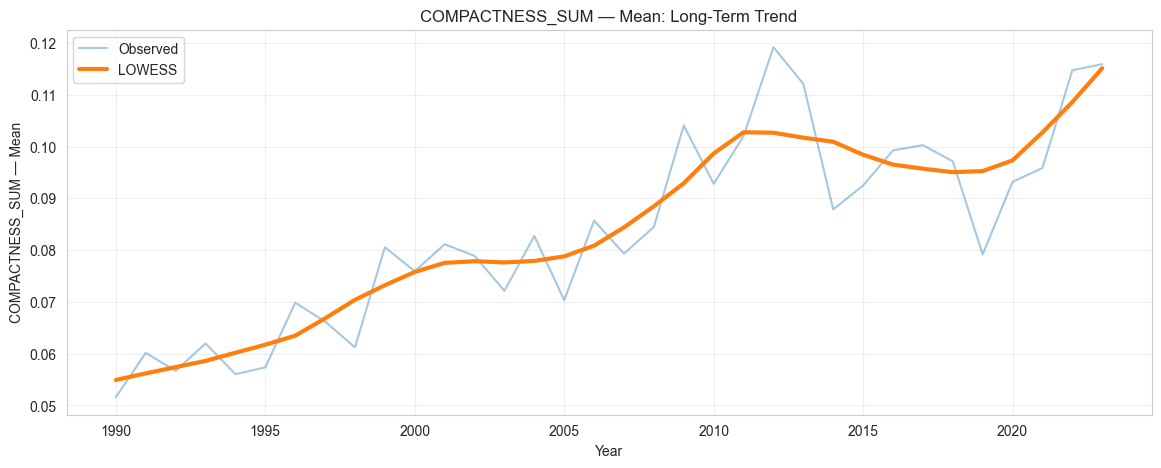

COMPACTNESS_SUM — Mean — Mann–Kendall
Trend: increasing
Sen slope: 0.0016
p-value: 0.0000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     67.47
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           2.21e-09
Time:                        12:01:00   Log-Likelihood:                 109.97
No. Observations:                  34   AIC:                            -215.9
Df Residuals:                      32   BIC:                            -212.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

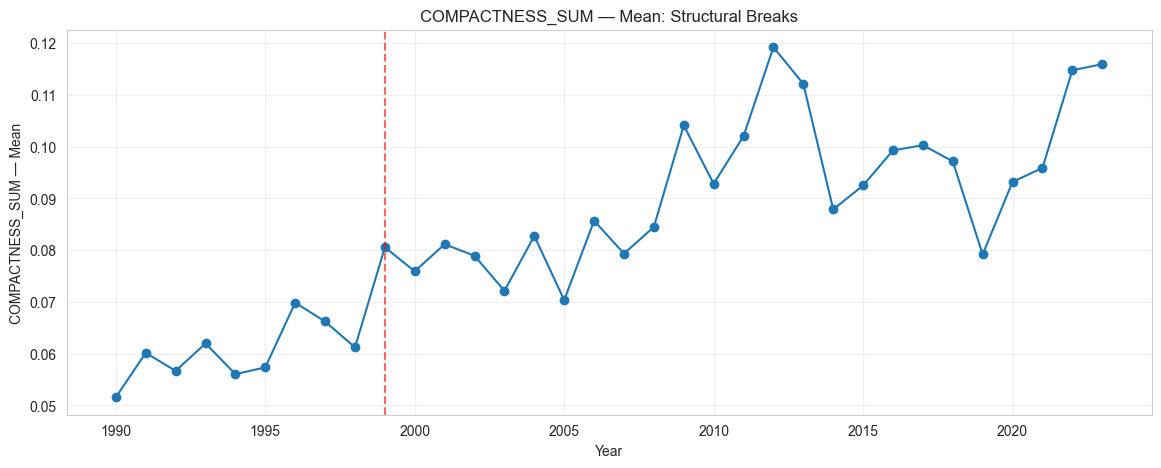


COMPACTNESS_SUM — Median — Stationarity
ADF p-value  : 0.4568
KPSS p-value : 0.0100


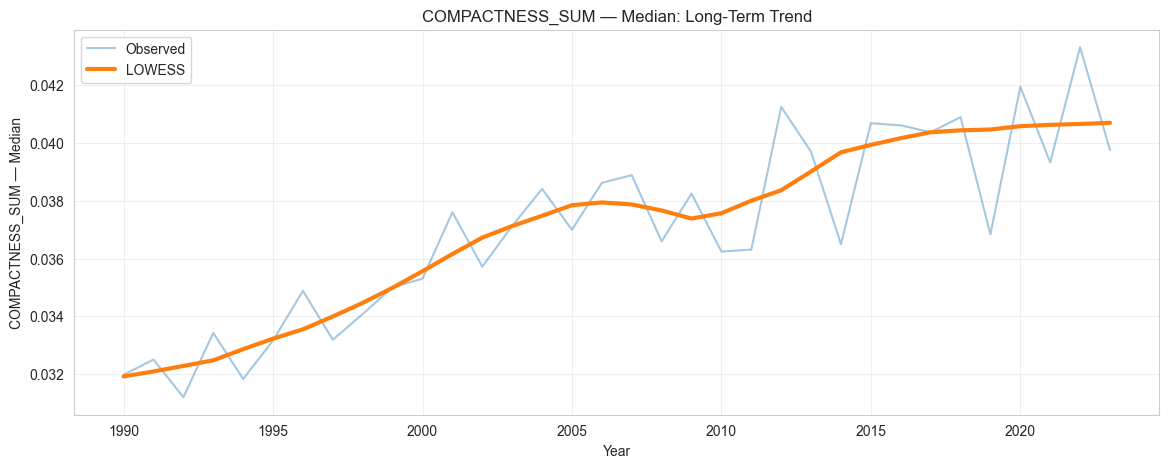

COMPACTNESS_SUM — Median — Mann–Kendall
Trend: increasing
Sen slope: 0.0003
p-value: 0.0000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     179.5
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           1.14e-14
Time:                        12:01:00   Log-Likelihood:                 172.84
No. Observations:                  34   AIC:                            -341.7
Df Residuals:                      32   BIC:                            -338.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

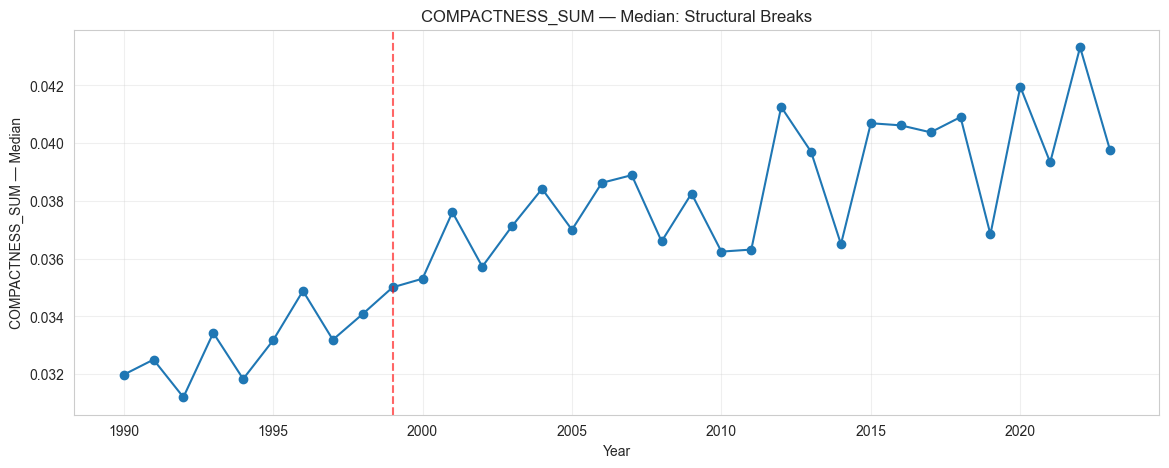


COMPACTNESS_SUM — Std — Stationarity
ADF p-value  : 0.4026
KPSS p-value : 0.0100


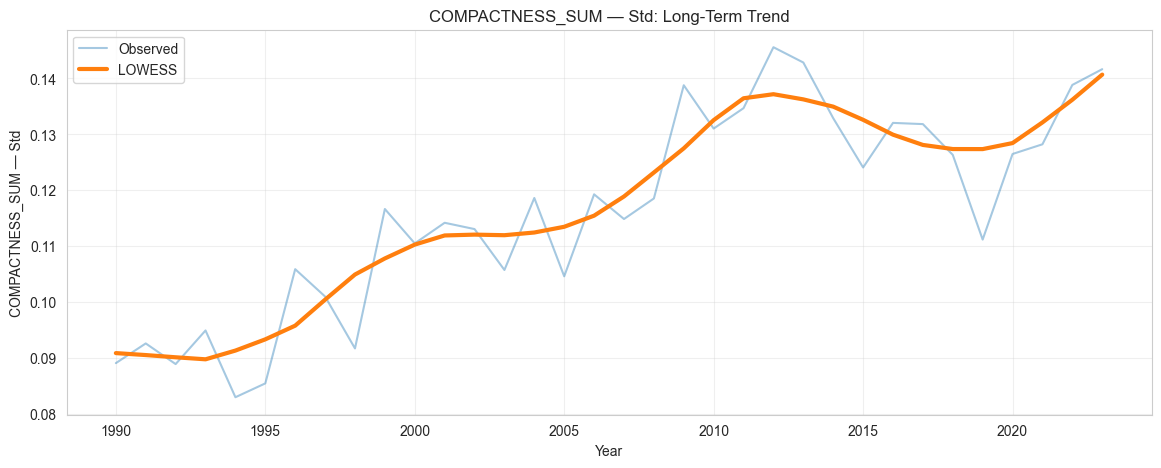

COMPACTNESS_SUM — Std — Mann–Kendall
Trend: increasing
Sen slope: 0.0015
p-value: 0.0000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     51.22
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           4.00e-08
Time:                        12:01:01   Log-Likelihood:                 109.65
No. Observations:                  34   AIC:                            -215.3
Df Residuals:                      32   BIC:                            -212.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

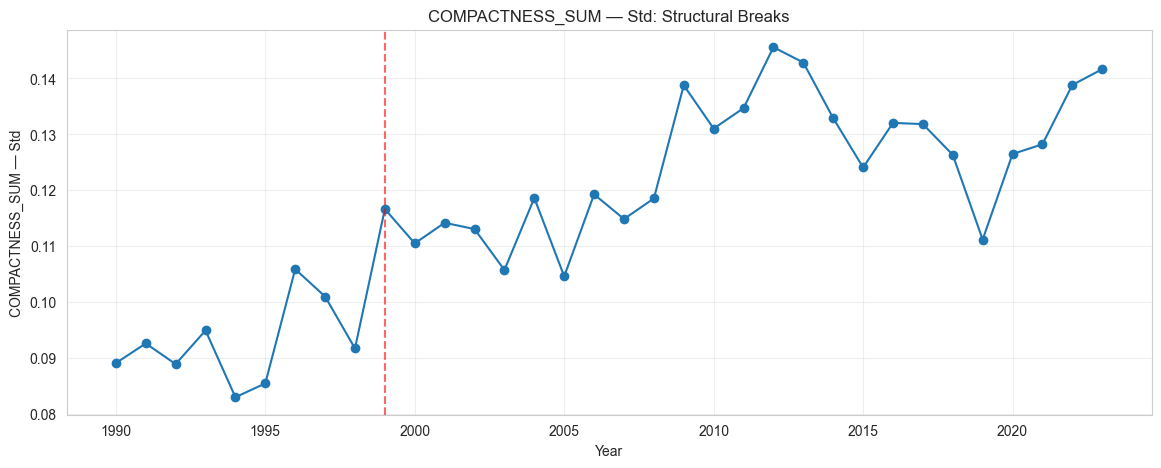


COMPACTNESS_SUM — Iqr — Stationarity
ADF p-value  : 0.6228
KPSS p-value : 0.0137


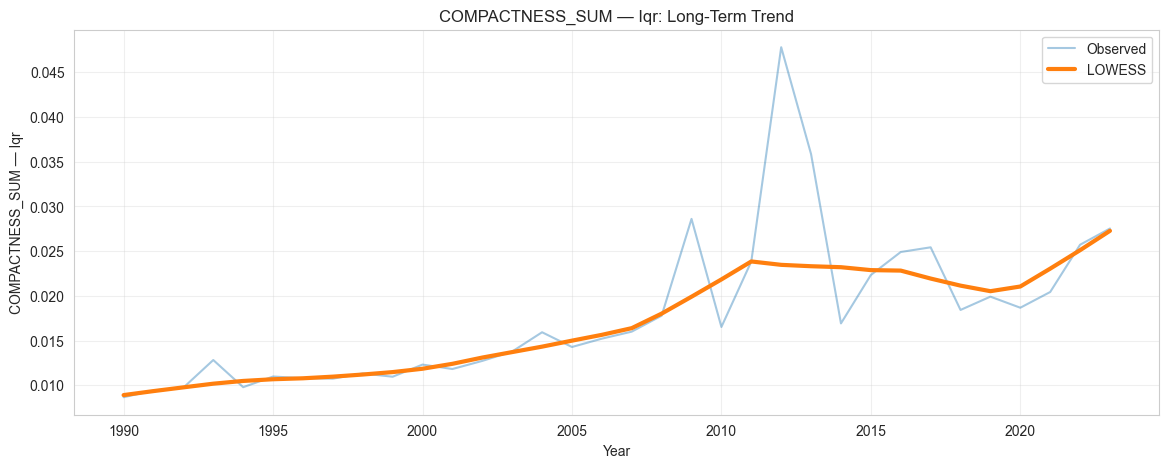

COMPACTNESS_SUM — Iqr — Mann–Kendall
Trend: increasing
Sen slope: 0.0005
p-value: 0.0000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     32.77
Date:                Tue, 27 Jan 2026   Prob (F-statistic):           2.41e-06
Time:                        12:01:01   Log-Likelihood:                 125.06
No. Observations:                  34   AIC:                            -246.1
Df Residuals:                      32   BIC:                            -243.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

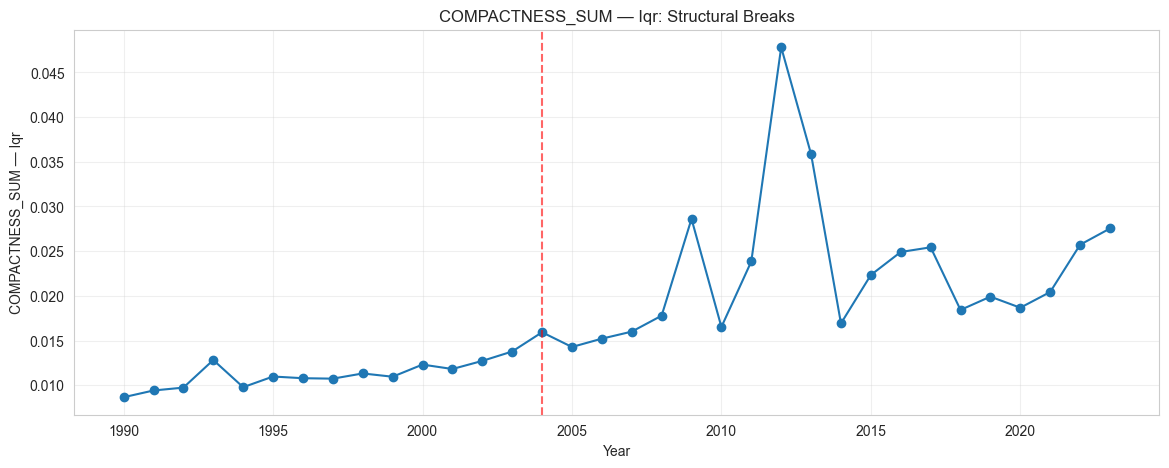

In [95]:
for col in ["mean", "median", "std", "iqr"]:
    run_trend_diagnostics(
        years=years,
        series=annual_stats[col].values,
        label=f"{measure.upper()} — {col.capitalize()}"
    )


# ============================================================
# Tier 3 — Distributional Shape Dynamics (Density–Value–Year)
# ============================================================
This tier examines **full distributional evolution**, including dispersion,
polarization, and potential bimodality not captured by summary statistics.


In [96]:
# Build density matrix
value_grid = np.linspace(ABT[measure].min(), ABT[measure].max(), 200)
years_sorted = np.sort(ABT["year"].unique())
Z = np.zeros((len(years_sorted), len(value_grid)))

for i, yr in enumerate(years_sorted):
    vals = ABT.loc[ABT["year"] == yr, measure].dropna().values
    if len(vals) < 5 or np.std(vals) == 0:
        Z[i, :] = np.nan
    else:
        kde = gaussian_kde(vals)
        Z[i, :] = kde(value_grid)


In [97]:
# 3D Density Surface (Plotly)
X, Y = np.meshgrid(value_grid, years_sorted)

fig = go.Figure(
    data=[go.Surface(x=X, y=Y, z=Z)]
)

fig.update_layout(
    title=f"3D Density Surface: {measure} Distribution Over Time",
    width=1400,
    height=900,
    scene=dict(
        xaxis_title=f"{measure} value",
        yaxis_title="Year",
        zaxis_title="Density",
        aspectmode="manual",
        aspectratio=dict(x=1.5, y=2.5, z=0.8)
    ),
    scene_camera=dict(eye=dict(x=1.6, y=1.8, z=0.9))
)

fig.show()


In [98]:
import numpy as np
import plotly.graph_objects as go

# ============================================================
# Prepare years
# ============================================================
years_sorted = np.sort(ABT["year"].unique())

# ============================================================
# Common binning across all years
# ============================================================
n_bins = 40
bin_edges = np.linspace(
    ABT[measure].min(),
    ABT[measure].max(),
    n_bins + 1
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# ============================================================
# Build figure
# ============================================================
fig = go.Figure()

for yr in years_sorted:
    vals = ABT.loc[ABT["year"] == yr, measure].dropna().values
    if len(vals) < 10:
        continue

    counts, _ = np.histogram(vals, bins=bin_edges)

    # Normalize within year (distributional shape only)
    if counts.max() > 0:
        counts = counts / counts.max()

    fig.add_trace(
        go.Scatter(
            x=bin_centers,
            y=counts + yr,                 # vertical stacking by year
            mode="lines+markers",

            line=dict(color="darkred", width=1),

            # IMPORTANT: almost-invisible markers (not zero opacity!)
            marker=dict(
                size=6,
                opacity=0.001,
                color="black"
            ),

            opacity=0.7,
            showlegend=False,

            text=[yr] * len(bin_centers),  # year for hover
            customdata=counts,             # normalized frequency for hover

            hoveron="points",

            hovertemplate=(
                "Year: %{text}<br>"
                + f"{measure}: "
                + "%{x:.3f}<br>"
                + "Frequency (normalized): %{customdata:.3f}"
            )
        )
    )

# ============================================================
# Layout: grids, axes, interaction
# ============================================================
fig.update_layout(
    title=f"Stacked Annual Histograms of {measure} (1980–2023)",
    xaxis_title=f"{measure} value",
    yaxis_title="Year",
    height=1200,
    width=1700,
    template="simple_white",

    hovermode="closest",

    # X axis (BAD)
    xaxis=dict(
        showgrid=True,
        gridcolor="rgba(0,0,0,0.25)",
        gridwidth=1,
        zeroline=False,
        nticks=10,
        minor=dict(
            ticks="inside",
            showgrid=True,
            gridcolor="rgba(0,0,0,0.10)",
            gridwidth=0.5
        )
    ),

    # Y axis (Year)
    yaxis=dict(
        showgrid=True,
        gridcolor="rgba(0,0,0,0.25)",
        gridwidth=1,
        zeroline=False,
        dtick=5,  # major grid every 5 years
        minor=dict(
            ticks="inside",
            showgrid=True,
            gridcolor="rgba(0,0,0,0.10)",
            gridwidth=0.5,
            dtick=1
        )
    )
)

fig.show()


In [100]:
!jupyter nbconvert --to html --no-input time_series_univariate.ipynb --output ../../../../output/Notebook_Outputs/time_series/time_series_EDA1th.html

[NbConvertApp] Converting notebook time_series_univariate.ipynb to html
[NbConvertApp] Writing 1518148 bytes to ..\..\..\..\output\Notebook_Outputs\time_series\time_series_EDA1th.html
